In [35]:
repeat = 0

In [36]:
DEVICE_ID = 2

# repeat
ref: https://docs.fast.ai/migrating_pytorch.html

In [37]:
repeat += 1

In [38]:
# from main_fastai import prepare
from main_fastai import prepare_train_valid_test

In [39]:
# %%debug
ds_type = 'Lp2TC'  # live, tid, L2C, L2T, T2C
ds_width = -1  #11
model_type = 'early_merge'
model_param = '0'  # '0_1_2_3_4_5'  # _6_7'

res=prepare_train_valid_test(
    ds_type=ds_type,
    ds_width=ds_width,
    model_type=model_type,
    model_param=model_param
); res.keys()

{'ds_type': 'Lp2TC', 'ds_width': -1, 'model_type': 'early_merge', 'model_param': [0], 'split_order': None, 'conv_wrapper': None}
Live Train/Valid
self.ratio: [29]
self.split_order [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Tid Test
self.ratio: [25]
self.split_order [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Csiq Test
self.ratio: [30]
self.split_order [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


dict_keys(['datum', 'model', 'metrics', 'dl_funcs', 'splitter'])

In [40]:
# %%debug
# ds_type = 'L2TC'  # live, tid, L2C, L2T, T2C
# ds_width = -1  #11
# model_type = 'early_merge'
# model_param = '0'  # '0_1_2_3_4_5'  # _6_7'

# res=prepare_train_valid_test(
#     ds_type=ds_type,
#     ds_width=ds_width,
#     model_type=model_type,
#     model_param=model_param
# ); res.keys()

In [41]:
# # %%debug
# ds_type = 'L2T'
# model_type = 'early_merge'
# model_param = '0_1_2_3_4_5'

# res=prepare_train_valid_test(ds_type=ds_type,model_type=model_type,model_param=model_param); res.keys()

In [42]:
# # %%debug
# ds_type = 'T2C'
# model_type = 'early_merge'
# model_param = '0_1_2_3_4_5'

# res=prepare_train_valid_test(ds_type=ds_type,model_type=model_type,model_param=model_param); res.keys()

In [43]:
WORKSPACE = '/mnt/workspace_6T/hong/test_merge'

In [44]:
from fastai.vision.all import *
from migrating_pytorch import *

In [45]:
batch_size=5

train_ds = res['datum'][0]
valid_ds = res['datum'][1] if res['datum'][1] is not None else res['datum'][0]

train_loader = res['dl_funcs'][0](batch_size=batch_size)
valid_loader = res['dl_funcs'][1]()

test_ds = res['datum'][2]
if type(test_ds) != list:
    test_loader = res['dl_funcs'][2]()
else:
    test_loader = [f() for f in res['dl_funcs'][2]]
# learn.validate(dl=test_loader)

In [46]:
d,t = next(iter(train_loader))

In [47]:
print(type(d), type(t))

<class 'list'> <class 'torch.Tensor'>


In [48]:
len(d), t.shape

(5, torch.Size([5, 1]))

In [49]:
d[0].shape

torch.Size([1, 3, 720, 480])

In [50]:
class List_Batch(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x_batch):
#         batch as list of list, output with heterogenius shape
#         loc, glo=y[0]  Shape(N,1,H,W), Shape(N,1)
#         y = [self.model(x) for x in x_batch]
        regs, glos, mean_locs = [], [], []
        for x in x_batch:
            loc, glo = self.model(x)
            diff = loc - glo
            
            reg = torch.mean(diff**2, dim=(2,3))
            mean_loc = torch.mean(loc, dim=(2,3))
            
            regs.append(reg)
            glos.append(glo)
            mean_locs.append(mean_loc)
        regs, glos, mean_locs = torch.cat(regs, dim=0), torch.cat(glos, dim=0), torch.cat(mean_locs, dim=0)
        res = torch.cat([regs, glos, mean_locs], dim=1)
        return res
    
model = List_Batch(res['model'])

# torch.nn.functional.mse_loss
class LossWithReg(nn.Module):
    def __init__(self, loss_func=torch.nn.functional.mse_loss):
        super().__init__()
        self.loss_func = loss_func
        
    def forward(self,o,t):
        reg, y = o[:,0:1], o[:,1:2]
        L1 = torch.mean(reg)
        L2 = self.loss_func(y,t)
        return L1 + L2
    
loss_with_reg = LossWithReg()

In [51]:
def accumulate(self, learn):
    "Store targs and preds from `learn`, using activation function and argmax as appropriate"
    pred = learn.pred
    pred = self.activation(pred)
#     bp()
    self.accum_values(pred,learn.y,learn)
    
from fastai.metrics import AccumMetric

AccumMetric.accumulate = accumulate

spr_glo = SpearmanCorrCoef(
    activation=lambda o: o[:,1]
)
spr_glo.func.func.__name__ = 'spr_glo'

spr_loc = SpearmanCorrCoef(
    activation=lambda o: o[:,2]
)
spr_loc.func.func.__name__ = 'spr_loc'

spr_Mean = SpearmanCorrCoef(
    activation=lambda o: (o[:,1] + o[:,2]) / 2
)
spr_Mean.func.func.__name__ = 'spr_Mean'

# PearsonCorrCoef
plcc_glo = PearsonCorrCoef(
    activation=lambda o: o[:,1]
)
plcc_glo.func.__name__ = 'plcc_glo'

plcc_loc = PearsonCorrCoef(
    activation=lambda o: o[:,2]
)
plcc_loc.func.__name__ = 'plcc_loc'

plcc_Mean = PearsonCorrCoef(
    activation=lambda o: (o[:,1] + o[:,2]) / 2
)
plcc_Mean.func.__name__ = 'plcc_Mean'


metrics = [spr_glo, plcc_glo, spr_loc, plcc_loc, spr_Mean, plcc_Mean]

[m.name for m in metrics]

['spr_glo', 'plcc_glo', 'spr_loc', 'plcc_loc', 'spr_Mean', 'plcc_Mean']

## assembly no_valid

In [52]:
from pdb import set_trace as bp


class ListedCudaCallback(Callback):
    "Move data to CUDA device"
    "Ref: https://github.com/fastai/fastai/blob/master/fastai/callback/data.py#L17"
    def __init__(self, device=None): self.device = ifnone(device, default_device()); self.debug=False
    def before_batch(self):
#         self.learn.xb,self.learn.yb = [[to_device(x) for x in xb] for xb in self.xb],to_device(self.yb)
        self.learn.xb,self.learn.yb = to_device(self.xb, self.device), to_device(self.yb, self.device)
    def before_fit(self): self.model.to(self.device)


class CudaCallback(Callback):
    "Move data to CUDA device"
    "Ref: https://github.com/fastai/fastai/blob/master/fastai/callback/data.py#L17"
    def __init__(self, device=None): self.device = ifnone(device, default_device()); self.debug=False
    def before_batch(self):
        # bp()
        # self.learn.xb,self.learn.yb = [[to_device(x) for x in xb] for xb in self.xb],to_device(self.yb)
        self.learn.xb,self.learn.yb = to_device(self.xb, self.device), to_device(self.yb, self.device)
    def before_fit(self): self.model.to(self.device)


class GradientClipping(Callback):
    "Gradient clipping during training."
    def __init__(self, clip:float = 0.1):
        self.clip = clip

    def before_step(self):
        torch.nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)


# from fastai.callback.data import CudaCallback   # this one is buggy

def _do_epoch(self):
    self._do_epoch_train()
    # self._do_epoch_validate()
    
Learner._do_epoch=_do_epoch
# learn.opt = OptimWrapper(torch.optim.AdamW(learn.model.parameters()))


from fastai.optimizer import *

data = DataLoaders(
    train_loader, valid_loader
)

DEVICE = torch.device('cuda:{}'.format(DEVICE_ID))
tocuda = ListedCudaCallback(DEVICE)
clip = GradientClipping(0.1)

learn = Learner(data,
                model,
                loss_func=loss_with_reg,
                metrics=metrics,
                cbs=[tocuda, 
                     #clip,
                     #SaveModelCallback(monitor='valid_loss'), 
                     SaveModelCallback(every_epoch=True)])
# learn.opt = OptimWrapper(torch.optim.AdamW(learn.model.parameters()))

In [53]:
# learn.splitter = res['splitter']

In [54]:
# learn.save??
# self.path/self.model_dir, ext='.pth'

In [55]:
# learn.path, learn.model_dir
# fold=2
# ds_type = 'live'
# model_type = 'early_merge'
# model_param = '0'

model_dir = 'ckpt_lateMerge_TVTRepeat_Tune_{}_{}_{}_{}'.format(repeat,ds_type,model_type,model_param)

# !mkdir $model_dir
print(WORKSPACE)
print(model_dir)

learn.path = Path(WORKSPACE)
learn.model_dir=model_dir

/mnt/workspace_6T/hong/test_merge
ckpt_lateMerge_TVTRepeat_Tune_1_Lp2TC_early_merge_0


In [56]:
# dl = learn.dls.train
# def one_batch(self):    
#     return next(iter(self))
# from types import MethodType
# dl.one_batch = MethodType(one_batch, dl)
# o=dl.one_batch()

# dl.n_inp=1

# learn.summary()

# model.to(DEVICE)

# x,t=next(iter(data.train))
# x,t=to_device(x,DEVICE),to_device(t,DEVICE)

# [e.flatten()[0] for e in x], t

# o = model(x); o

# t.shape,o.shape

# loss_with_reg(o,t)

# # print(batch_size)
# o[0].shape, o[1].shape

# batch_size

In [57]:
# learn.opt = OptimWrapper(torch.optim.AdamW(learn.model.parameters()))
learn.opt = OptimWrapper(torch.optim.Adam(learn.model.parameters(), weight_decay=1e-4))
# learn.opt = OptimWrapper(torch.optim.SGD(learn.model.parameters(), weight_decay=1e-4, momentum=0.9,lr=0))

## fit: no valid

In [58]:
model_param, learn.opt.opt

('0',
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0.0001
 ))

In [59]:
lr = 3e-4

In [60]:
# %%debug
# lr = lr/10
print(lr)
learn.fit(1, lr=lr/10)

0.0003


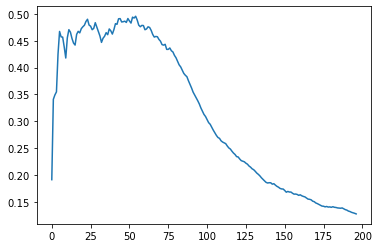

In [61]:
learn.recorder.plot_loss(skip_start=0, with_valid=False)

In [62]:
# lr = lr/10
print(lr)
learn.fit(50, lr=lr)

0.0003


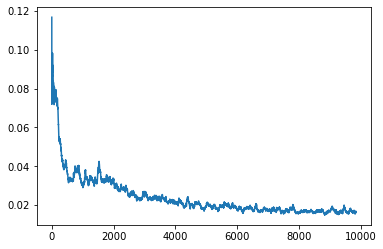

In [63]:
learn.recorder.plot_loss(skip_start=0, with_valid=False)

In [64]:
learn.validate(dl=test_loader[0])

(#7) [0.07383650541305542,0.28130416028449223,0.3375764257764969,0.280371399953477,0.3329408674662551,0.28075072810353435,0.3353777604768427]

In [65]:
learn.validate(dl=test_loader[1])

(#7) [0.04885979741811752,0.6391365837094776,0.6718936826751347,0.6396100458423633,0.6647967148820028,0.6394222001176084,0.6685820640843465]

## fit: no valid, has clip

In [25]:
model_param, learn.opt.opt

('0',
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0.0001
 ))

In [26]:
lr = 3e-4

In [27]:
# %%debug
# lr = lr/10
print(lr)
learn.fit(1, lr=lr/10)

0.0003


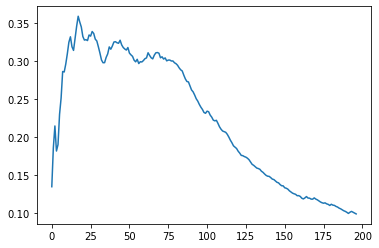

In [29]:
learn.recorder.plot_loss(skip_start=0, with_valid=False)

In [30]:
# lr = lr/10
print(lr)
learn.fit(50, lr=lr)

0.0003


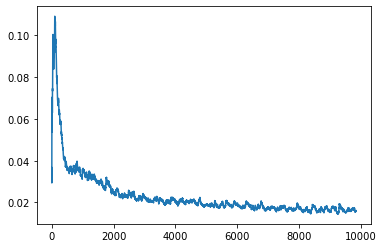

In [32]:
learn.recorder.plot_loss(skip_start=0, with_valid=False)

In [33]:
learn.validate(dl=test_loader[0])

(#7) [0.07730630785226822,0.28383338195229096,0.34074139141994303,0.27892648977884543,0.33415251151802305,0.28171119251840787,0.3377683102459932]

In [34]:
learn.validate(dl=test_loader[1])

(#7) [0.0487702339887619,0.6392827085227589,0.6761181222681028,0.6404514483519677,0.6706657452045302,0.6397647254749592,0.6736785142730848]

## fit: OC Adam180

In [24]:
model_param, learn.opt.opt

('0',
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0.0001
 ))

In [25]:
lr = 3e-4

In [26]:
# %%debug
# lr = lr/10
print(lr)
learn.fit(1, lr=lr/10)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.115112,0.072219,0.531431,0.433809,0.534164,0.423618,0.533067,0.428345,00:44


Better model found at epoch 0 with valid_loss value: 0.07221867889165878.


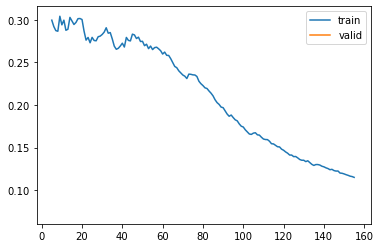

In [27]:
learn.recorder.plot_loss()

In [28]:
# lr = lr/10
print(lr)
learn.fit(50, lr=lr)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.055996,0.042544,0.823410,0.803086,0.840343,0.829527,0.831087,0.817132,00:39
1,0.042051,0.033678,0.853980,0.861651,0.856986,0.866360,0.856185,0.863979,00:38
2,0.035018,0.035014,0.866408,0.883466,0.870174,0.886490,0.867615,0.884676,00:38
3,0.036564,0.027894,0.874185,0.889035,0.877276,0.891101,0.875663,0.889934,00:38
4,0.033848,0.027788,0.857967,0.886450,0.858497,0.887286,0.858182,0.886920,00:37
5,0.032878,0.027042,0.891857,0.900981,0.891939,0.902546,0.891909,0.901750,00:38
6,0.030191,0.025889,0.878658,0.903216,0.879151,0.905100,0.879031,0.904125,00:37
7,0.032774,0.024883,0.906091,0.912989,0.906190,0.914221,0.906089,0.913715,00:38
8,0.027168,0.023655,0.915775,0.921740,0.915541,0.923630,0.915405,0.922754,00:37
9,0.030004,0.025282,0.910070,0.918876,0.908586,0.916547,0.909523,0.918154,00:37


Better model found at epoch 0 with valid_loss value: 0.04254427179694176.
Better model found at epoch 1 with valid_loss value: 0.03367796167731285.
Better model found at epoch 3 with valid_loss value: 0.02789420448243618.
Better model found at epoch 4 with valid_loss value: 0.027787890285253525.
Better model found at epoch 5 with valid_loss value: 0.027041980996727943.
Better model found at epoch 6 with valid_loss value: 0.025889184325933456.
Better model found at epoch 7 with valid_loss value: 0.02488287352025509.
Better model found at epoch 8 with valid_loss value: 0.023654993623495102.
Better model found at epoch 10 with valid_loss value: 0.02157963626086712.
Better model found at epoch 11 with valid_loss value: 0.020640207454562187.
Better model found at epoch 15 with valid_loss value: 0.01956867054104805.
Better model found at epoch 18 with valid_loss value: 0.01787894032895565.
Better model found at epoch 22 with valid_loss value: 0.01783832535147667.
Better model found at epoch 

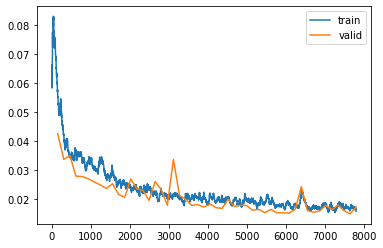

In [29]:
learn.recorder.plot_loss()

In [30]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.28393023748862467.


(#7) [0.0611860454082489,0.28393023748862467,0.34877180235253147,0.28326251389141754,0.344721906634886,0.28365451661322577,0.3469651168945487]

In [31]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6447319528952883.


(#7) [0.04675496369600296,0.6447319528952883,0.6847374523033953,0.6450184746730658,0.6787029472853219,0.6448609680699405,0.6820716006686198]

In [24]:
model_param, learn.opt.opt

('0',
 SGD (
 Parameter Group 0
     dampening: 0
     lr: 0
     momentum: 0.9
     nesterov: False
     weight_decay: 0.0001
 ))

In [25]:
lr = 1e-2

In [26]:
from fastai.callback.tracker import ReduceLROnPlateau

In [27]:
# lr = lr/10
print(lr)
learn.fit(50, lr=lr, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0, patience=2))

0.01


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.080446,0.070541,0.916218,0.895464,0.546040,0.289754,0.551288,0.329462,00:42
1,0.078303,0.074012,0.558831,0.605985,0.546663,0.292214,0.552608,0.341529,00:35
2,0.079218,0.070939,0.552746,0.519193,0.548413,0.293536,0.550519,0.349030,00:36
3,0.077520,0.072143,0.551283,0.488857,0.548590,0.298305,0.550440,0.353326,00:36
4,0.078324,0.072738,0.549992,0.470856,0.548468,0.305641,0.550546,0.359357,00:36
5,0.076116,0.071411,0.549008,0.462959,0.548241,0.310841,0.550720,0.361505,00:36
6,0.073927,0.072128,0.547850,0.455816,0.548236,0.317410,0.550239,0.365227,00:36
7,0.074245,0.072490,0.547116,0.450599,0.549276,0.322425,0.550350,0.368535,00:35
8,0.080471,0.071949,0.546751,0.446420,0.549236,0.327320,0.548702,0.370629,00:36
9,0.081443,0.071668,0.546840,0.444473,0.548717,0.332721,0.548322,0.374979,00:36


Better model found at epoch 0 with valid_loss value: 0.07054104655981064.
Better model found at epoch 17 with valid_loss value: 0.07051011919975281.


IndexError: list index out of range

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.validate(dl=test_loader[0])

In [ ]:
learn.validate(dl=test_loader[1])

In [24]:
model_param, learn.opt.opt

('0',
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0.0001
 ))

In [25]:
lr = 3e-4

In [26]:
# %%debug
# lr = lr/10
print(lr)
learn.fit(1, lr=lr/10)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.182754,0.105862,0.493169,0.321038,0.493557,0.301300,0.492651,0.311842,00:42


Better model found at epoch 0 with valid_loss value: 0.10586199909448624.


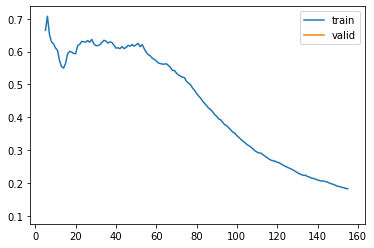

In [27]:
learn.recorder.plot_loss()

In [28]:
# lr = lr/10
print(lr)
learn.fit(50, lr=lr)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.067847,0.047299,0.827035,0.796552,0.832524,0.802765,0.830333,0.799982,00:37
1,0.041177,0.033858,0.866937,0.877997,0.870347,0.881159,0.868920,0.879480,00:37
2,0.041535,0.030889,0.878803,0.886780,0.880052,0.889504,0.879552,0.888035,00:37
3,0.033741,0.032000,0.890133,0.900954,0.892098,0.903157,0.890970,0.901969,00:37
4,0.032355,0.030694,0.893922,0.904351,0.896160,0.906246,0.894540,0.905181,00:38
5,0.036595,0.030563,0.884600,0.893502,0.886216,0.894107,0.884769,0.893788,00:37
6,0.035494,0.036757,0.901185,0.911932,0.901971,0.912149,0.901775,0.912032,00:35
7,0.032484,0.035719,0.902643,0.914724,0.902436,0.914949,0.902598,0.914825,00:36
8,0.032975,0.025677,0.910272,0.919335,0.910682,0.919175,0.910434,0.919269,00:36
9,0.029990,0.027278,0.923032,0.924780,0.923022,0.924801,0.923066,0.924791,00:36


Better model found at epoch 0 with valid_loss value: 0.04729917645454407.
Better model found at epoch 1 with valid_loss value: 0.03385826200246811.
Better model found at epoch 2 with valid_loss value: 0.030889205634593964.
Better model found at epoch 4 with valid_loss value: 0.03069380857050419.
Better model found at epoch 5 with valid_loss value: 0.0305627528578043.
Better model found at epoch 8 with valid_loss value: 0.025676999241113663.
Better model found at epoch 12 with valid_loss value: 0.023463604971766472.
Better model found at epoch 13 with valid_loss value: 0.022951742634177208.
Better model found at epoch 18 with valid_loss value: 0.020380709320306778.
Better model found at epoch 25 with valid_loss value: 0.01891929842531681.
Better model found at epoch 28 with valid_loss value: 0.01884782500565052.
Better model found at epoch 29 with valid_loss value: 0.018580682575702667.
Better model found at epoch 30 with valid_loss value: 0.018060622736811638.
Better model found at epo

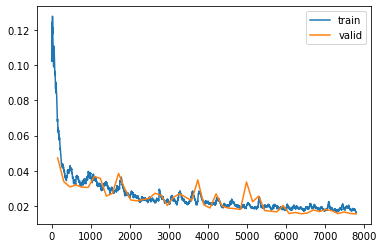

In [29]:
learn.recorder.plot_loss()

In [30]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2862595183139887.


(#7) [0.08182340860366821,0.2862595183139887,0.36111315166515,0.2889033072704211,0.36074410238155175,0.2875216699222512,0.36095528377441066]

In [31]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6217210132859565.


(#7) [0.04802543669939041,0.6217210132859565,0.6725093182240465,0.6208702244951172,0.6673829444112791,0.6213920315194427,0.6701529589285959]

In [36]:
model_param, learn.opt.opt

('0_1',
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.0003
     weight_decay: 0.01
 ))

In [28]:
lr = 3e-4

In [29]:
# %%debug
# lr = lr/10
print(lr)
learn.fit(1, lr=lr/10)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.130605,0.075594,0.497225,0.455950,0.503684,0.449000,0.501246,0.452669,00:51


Better model found at epoch 0 with valid_loss value: 0.07559409737586975.


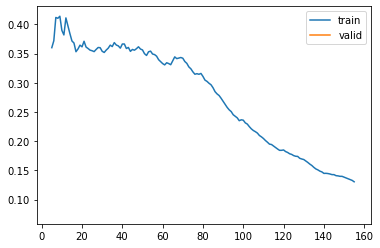

In [30]:
learn.recorder.plot_loss()

In [31]:
# lr = lr/10
print(lr)
learn.fit(50, lr=lr)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.064952,0.063262,0.679052,0.669438,0.646528,0.665742,0.659705,0.668213,00:45
1,0.049802,0.042541,0.848328,0.831132,0.850396,0.831850,0.847836,0.831511,00:46
2,0.034660,0.036278,0.874021,0.870218,0.874917,0.870471,0.874199,0.870337,00:46
3,0.031197,0.037652,0.883020,0.881242,0.884363,0.882132,0.883277,0.881634,00:46
4,0.029784,0.032778,0.890015,0.890132,0.889885,0.890899,0.890200,0.890481,00:46
5,0.028745,0.036353,0.896340,0.891741,0.896171,0.892730,0.896571,0.892142,00:47
6,0.030386,0.041359,0.890886,0.896581,0.890157,0.898105,0.890401,0.897241,00:46
7,0.029059,0.030654,0.901025,0.898114,0.901228,0.899860,0.901109,0.898899,00:47
8,0.026663,0.034131,0.908666,0.903234,0.908759,0.905441,0.908992,0.904225,00:48
9,0.026840,0.031447,0.898381,0.898730,0.899328,0.900884,0.898248,0.899719,00:48


Better model found at epoch 0 with valid_loss value: 0.06326162070035934.
Better model found at epoch 1 with valid_loss value: 0.04254131019115448.
Better model found at epoch 2 with valid_loss value: 0.03627800568938255.
Better model found at epoch 4 with valid_loss value: 0.032777611166238785.
Better model found at epoch 7 with valid_loss value: 0.030654219910502434.
Better model found at epoch 10 with valid_loss value: 0.028164802119135857.
Better model found at epoch 13 with valid_loss value: 0.027120735496282578.
Better model found at epoch 15 with valid_loss value: 0.0269904974848032.
Better model found at epoch 16 with valid_loss value: 0.026025906205177307.
Better model found at epoch 17 with valid_loss value: 0.02569659985601902.
Better model found at epoch 19 with valid_loss value: 0.02308814227581024.
Better model found at epoch 22 with valid_loss value: 0.020720433443784714.
Better model found at epoch 24 with valid_loss value: 0.018290134146809578.
Better model found at ep

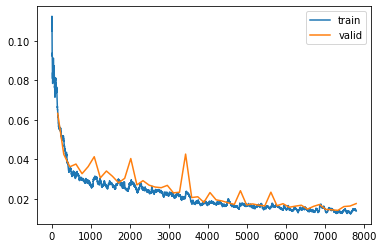

In [32]:
learn.recorder.plot_loss()

In [33]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2789796361489073.


(#7) [0.0706075057387352,0.2789796361489073,0.3266459192717023,0.2597225385576776,0.3055403450447392,0.27007474102430823,0.3174231892872592]

In [34]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6488166573948155.


(#7) [0.04529927298426628,0.6488166573948155,0.6976729933709723,0.6446069934071147,0.6828087918776542,0.6468144047057808,0.6910775410589889]

In [27]:
model_param

'0_1'

In [28]:
lr=1e-5

In [29]:
learn.fit_one_cycle(10, lr_max=lr)

epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.415932,0.384678,0.538850,0.462013,-0.539986,-0.413414,-0.539668,-0.372999,00:50
1,0.321607,0.229359,0.544871,0.426876,-0.487422,-0.311340,0.544325,0.432735,00:43
2,0.084262,0.072447,0.541843,0.474528,0.545456,0.461818,0.543489,0.468709,00:44
3,0.065771,0.069810,0.532341,0.529609,0.546843,0.488066,0.540527,0.511265,00:44
4,0.063593,0.068582,0.526284,0.554479,0.547251,0.503908,0.538337,0.532966,00:45
5,0.063808,0.069097,0.522339,0.568576,0.548162,0.514932,0.536731,0.546770,00:45
6,0.064907,0.065403,0.523404,0.575448,0.548961,0.521116,0.537348,0.553554,00:45
7,0.063110,0.064590,0.522008,0.579129,0.549097,0.524587,0.537383,0.557107,00:45
8,0.063020,0.065216,0.520487,0.580905,0.549191,0.526089,0.537306,0.558840,00:45
9,0.060493,0.065038,0.520544,0.581025,0.549191,0.526258,0.537306,0.559018,00:46


Better model found at epoch 0 with valid_loss value: 0.38467827439308167.
Better model found at epoch 1 with valid_loss value: 0.22935894131660461.
Better model found at epoch 2 with valid_loss value: 0.0724465474486351.
Better model found at epoch 3 with valid_loss value: 0.06980959326028824.
Better model found at epoch 4 with valid_loss value: 0.06858225911855698.
Better model found at epoch 6 with valid_loss value: 0.06540267169475555.
Better model found at epoch 7 with valid_loss value: 0.06459037214517593.


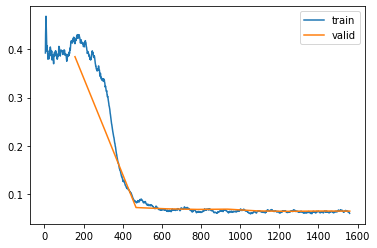

In [30]:
learn.recorder.plot_loss()

In [31]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.1548609235667639.


(#7) [0.04309142008423805,0.1548609235667639,0.35882877370830557,0.17752981601006004,0.3479977566380741,0.1611143470912697,0.35670480560962325]

In [32]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.4196224976296344.


(#7) [0.0629066601395607,0.4196224976296344,0.5603466539508408,0.3887973680305843,0.5154738565417393,0.40348748942515306,0.5411211543514302]

In [ ]:
# model_param = 1

In [32]:
lr=1e-5

In [33]:
learn.fit_one_cycle(10, lr_max=lr)

epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.078997,0.067229,0.546236,0.555834,0.546365,0.537298,0.548698,0.547321,00:34
1,0.079485,0.067116,0.546383,0.556501,0.546427,0.537993,0.548858,0.548002,00:35
2,0.074287,0.067487,0.546828,0.557650,0.546605,0.538868,0.548669,0.549047,00:35
3,0.082098,0.067358,0.546781,0.558627,0.546605,0.539695,0.548883,0.549959,00:36
4,0.076504,0.066879,0.546781,0.559352,0.546694,0.540801,0.549099,0.550863,00:35
5,0.073360,0.066930,0.546902,0.560071,0.546694,0.541353,0.549238,0.551519,00:36
6,0.080899,0.066830,0.547001,0.560427,0.546839,0.541851,0.549238,0.551939,00:36
7,0.072222,0.066718,0.547001,0.560726,0.547002,0.542058,0.549231,0.552200,00:35
8,0.078769,0.066769,0.547001,0.560829,0.547002,0.542141,0.549231,0.552295,00:36
9,0.072807,0.066758,0.547001,0.560840,0.547002,0.542162,0.549231,0.552311,00:36


Better model found at epoch 0 with valid_loss value: 0.06722892075777054.
Better model found at epoch 1 with valid_loss value: 0.06711602956056595.
Better model found at epoch 4 with valid_loss value: 0.06687894463539124.
Better model found at epoch 6 with valid_loss value: 0.06683003902435303.
Better model found at epoch 7 with valid_loss value: 0.06671848893165588.


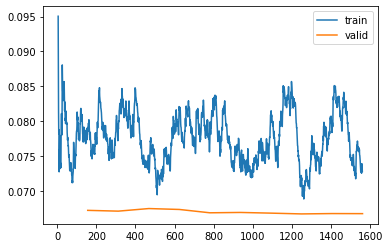

In [34]:
learn.recorder.plot_loss()

In [35]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.149121335569376.


(#7) [0.05260084196925163,0.149121335569376,0.3353392029050456,0.17413471635023572,0.32743970336643585,0.15982725921110905,0.3335659498313883]

In [36]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.3655400015849708.


(#7) [0.07421224564313889,0.3655400015849708,0.5059748183075199,0.3534233195033695,0.4672736535531212,0.3590238899454159,0.48736155100047207]

In [27]:
lr=1e-5

In [28]:
learn.fit_one_cycle(10, lr_max=lr)

epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.516387,0.496439,0.525647,0.492921,0.530425,0.521489,0.528919,0.510494,00:43
1,0.383769,0.147509,0.539510,0.482444,0.540655,0.469731,0.541515,0.476126,00:34
2,0.100162,0.080386,0.544929,0.514234,0.542396,0.496176,0.542076,0.505631,00:34
3,0.085689,0.069745,0.545811,0.527113,0.546346,0.509700,0.545355,0.518754,00:34
4,0.082306,0.070241,0.546689,0.539355,0.545407,0.520878,0.545588,0.530728,00:35
5,0.077779,0.070630,0.546417,0.547414,0.545510,0.528677,0.548136,0.538819,00:34
6,0.081412,0.067756,0.546128,0.551585,0.545916,0.533141,0.548699,0.543099,00:35
7,0.079517,0.067505,0.546236,0.554448,0.546071,0.535916,0.548770,0.545934,00:35
8,0.077338,0.067257,0.546136,0.555515,0.546365,0.536999,0.548698,0.547008,00:35
9,0.077104,0.067192,0.546236,0.555641,0.546365,0.537140,0.548698,0.547139,00:35


Better model found at epoch 0 with valid_loss value: 0.4964390993118286.
Better model found at epoch 1 with valid_loss value: 0.14750857651233673.
Better model found at epoch 2 with valid_loss value: 0.08038604259490967.
Better model found at epoch 3 with valid_loss value: 0.0697450339794159.
Better model found at epoch 6 with valid_loss value: 0.06775610893964767.
Better model found at epoch 7 with valid_loss value: 0.06750529259443283.
Better model found at epoch 8 with valid_loss value: 0.06725698709487915.
Better model found at epoch 9 with valid_loss value: 0.06719200313091278.


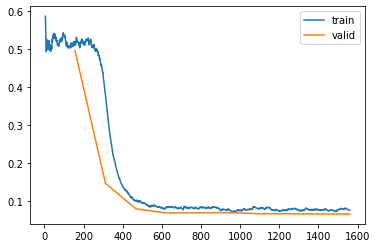

In [29]:
learn.recorder.plot_loss()

In [30]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.14870496881660974.


(#7) [0.05258267745375633,0.14870496881660974,0.3334352785344984,0.17391085249007945,0.326002642868751,0.15983170190119578,0.33187557347544905]

In [31]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.3631852552340059.


(#7) [0.07521592080593109,0.3631852552340059,0.5023446479133885,0.35185269717415757,0.4639675273430067,0.35720788472655574,0.4838103309729168]

In [ ]:
lr = 3e-4

In [28]:
# %%debug
# lr = lr/10
print(lr)
learn.fit(1, lr=lr/10)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.165942,0.082530,0.518469,0.508013,0.511386,0.473494,0.516934,0.491527,01:01


Better model found at epoch 0 with valid_loss value: 0.08252962678670883.


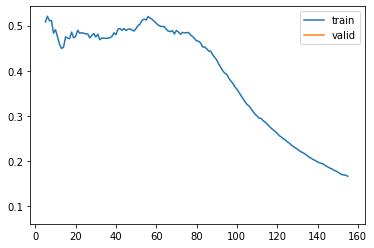

In [29]:
learn.recorder.plot_loss()

In [30]:
# lr = lr/10
print(lr)
learn.fit(179, lr=lr)

0.0003


epoch,train_loss,valid_loss,spr_glo,plcc_glo,spr_loc,plcc_loc,spr_Mean,plcc_Mean,time
0,0.067122,0.048484,0.814584,0.765568,0.775857,0.750775,0.790428,0.760006,00:36
1,0.041641,0.034395,0.890445,0.893608,0.889533,0.892607,0.889755,0.893284,00:36
2,0.036628,0.041811,0.900034,0.902763,0.902138,0.902092,0.900902,0.902543,00:36
3,0.035124,0.027718,0.906174,0.906390,0.906247,0.906066,0.906402,0.906258,00:36
4,0.031651,0.029099,0.895162,0.904151,0.895322,0.903653,0.895412,0.903967,00:37
5,0.032470,0.028666,0.905031,0.906719,0.904734,0.907028,0.905183,0.906862,00:37
6,0.034518,0.026180,0.915593,0.911250,0.915968,0.911180,0.915911,0.911237,00:37
7,0.032085,0.027632,0.914861,0.910200,0.915069,0.909565,0.915083,0.909938,00:37
8,0.029219,0.030258,0.919295,0.911778,0.919491,0.911549,0.919392,0.911680,00:38
9,0.031666,0.030096,0.921181,0.913237,0.921146,0.913023,0.921212,0.913143,00:37


Better model found at epoch 0 with valid_loss value: 0.04848364368081093.
Better model found at epoch 1 with valid_loss value: 0.03439512848854065.
Better model found at epoch 3 with valid_loss value: 0.02771819196641445.
Better model found at epoch 6 with valid_loss value: 0.02617965266108513.
Better model found at epoch 13 with valid_loss value: 0.025424592196941376.
Better model found at epoch 14 with valid_loss value: 0.025045081973075867.
Better model found at epoch 16 with valid_loss value: 0.024579370394349098.
Better model found at epoch 17 with valid_loss value: 0.02363789826631546.
Better model found at epoch 23 with valid_loss value: 0.02274678274989128.
Better model found at epoch 24 with valid_loss value: 0.020393583923578262.
Better model found at epoch 27 with valid_loss value: 0.01919487491250038.
Better model found at epoch 29 with valid_loss value: 0.01884983666241169.
Better model found at epoch 31 with valid_loss value: 0.018197806552052498.
Better model found at ep

IndexError: list index out of range

IndexError: list index out of range

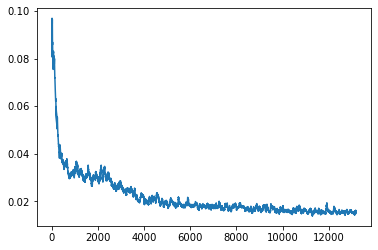

In [31]:
learn.recorder.plot_loss()

In [32]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2505690111975016.


(#7) [0.07191693782806396,0.2505690111975016,0.28370784196460364,0.24966220990308252,0.27446426341854263,0.25019441858123503,0.2794265969713882]

In [33]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6437392612700303.


(#7) [0.0502624474465847,0.6437392612700303,0.6642116435778549,0.6432193481311903,0.6495936072655102,0.6435996218597284,0.6576296615072694]

In [34]:
learn.load('model_5')

/mnt/pub_workspace_2T/anaconda3/envs/fastaiv2/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [35]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2102280427896336.


(#7) [0.06675933301448822,0.2102280427896336,0.21690953598880067,0.21062560949508574,0.21660231818011155,0.21042385372920924,0.21679279079356603]

In [36]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6662999180571246.


(#7) [0.06038583815097809,0.6662999180571246,0.6427540518720459,0.6652616530801617,0.6430775446824412,0.6658692792889338,0.6429013907572678]

In [37]:
learn.load('model_1')

In [38]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2288560622803017.


(#7) [0.07659927010536194,0.2288560622803017,0.27264411539447153,0.23222657493422236,0.27142643307902636,0.23030220034522617,0.2721689838324337]

In [39]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6744467851996696.


(#7) [0.051932159811258316,0.6744467851996696,0.6830244192327397,0.6724047054846466,0.6799782169828532,0.6735836907724081,0.681784829859223]

In [40]:
learn.load('model_10')

In [41]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2302834518169549.


(#7) [0.067973792552948,0.2302834518169549,0.2546063750943429,0.2292807286246747,0.2546696400439097,0.22985054332527,0.2546350573541433]

In [42]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6659393869299637.


(#7) [0.051990099251270294,0.6659393869299637,0.6640839205703034,0.6658243680309719,0.6651421058539774,0.6658914700838459,0.6645265878289773]

In [43]:
learn.load('model_20')

In [44]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.24470043074615888.


(#7) [0.05298008769750595,0.24470043074615888,0.28423240953337114,0.24234478005041749,0.2827691218359014,0.24368667223195706,0.2835710261860259]

In [45]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6499069349341337.


(#7) [0.060681987553834915,0.6499069349341337,0.6733780256282393,0.6510235698163293,0.6752242599519351,0.6504581387565789,0.674242154853578]

In [46]:
learn.load('model_50')

In [47]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.254637687798506.


(#7) [0.07009164243936539,0.254637687798506,0.2979496069162618,0.2540073803286871,0.28980515427705433,0.2542734562232826,0.2940849547199983]

In [48]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6449711552513281.


(#7) [0.04933801665902138,0.6449711552513281,0.6722599776449398,0.6452938456226439,0.6601446494985791,0.6451592781300565,0.666699734723722]

In [49]:
learn.load('model_70')

In [50]:
learn.validate(dl=test_loader[0])

Better model found at epoch 0 with valid_loss value: 0.2561107293706127.


(#7) [0.07466726005077362,0.2561107293706127,0.29493050530089104,0.2554173176808171,0.286301654047542,0.2557418862623324,0.2909594838313222]

In [51]:
learn.validate(dl=test_loader[1])

Better model found at epoch 0 with valid_loss value: 0.6411176433580072.


(#7) [0.04860012233257294,0.6411176433580072,0.6702085174252408,0.6409964624023387,0.6567244666636629,0.6410056361988606,0.6641686595278071]

# lr range test

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=1.2022644114040304e-05)

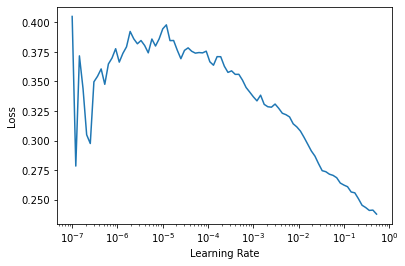

In [24]:
# %%debug
# tocuda.debug=True
res = learn.lr_find(); res

In [ ]:
# %%debug
# tocuda.debug=True
res = learn.lr_find(); res

In [ ]:
# %%debug
# tocuda.debug=True
res = learn.lr_find(); res

## clear gpu memory

In [30]:
import gc

learn = None
data = None
model= None

gc.collect()
torch.cuda.empty_cache()